# Atmospheric Image Segmentation using K-means

In [25]:
import numpy as np
import cv2
import sys
import argparse
from matplotlib import pyplot as plt
%matplotlib inline
from __future__ import print_function
from pathlib import Path
from pyts.utils import segmentation
from skimage.color import rgb2gray
from scipy import ndimage
import warnings 
warnings.filterwarnings("ignore")

In [26]:
#Load a color image in grayscale
img = cv2.imread('image.jpg') # 0 for grayscale and 1 for color. #*.jpeg 
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])

In [27]:
#counting the number of coins
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [28]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

In [29]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

In [30]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

In [31]:
#threshold
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

In [32]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [33]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

In [34]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

In [35]:
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7ff5c0893ca0>)

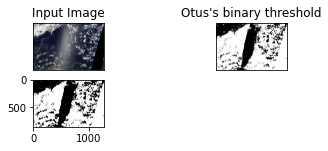

In [36]:
#plotting
plt.subplot(421),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(422),plt.imshow(thresh, 'gray')
plt.title("Otus's binary threshold"), plt.xticks([]), plt.yticks([])
plt.subplot(423),plt.imshow(opening, 'gray')

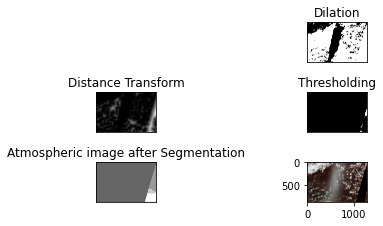

In [84]:
plt.title("morphologyEx (Opening)"), plt.xticks([]), plt.yticks([])
plt.subplot(424),plt.imshow(sure_bg, 'gray')
plt.title("Dilation"), plt.xticks([]), plt.yticks([])
plt.subplot(425),plt.imshow(dist_transform, 'gray')
plt.title("Distance Transform"), plt.xticks([]), plt.yticks([])
plt.subplot(426),plt.imshow(sure_fg, 'gray')
plt.title("Thresholding"), plt.xticks([]), plt.yticks([])
plt.subplot(427),plt.imshow(markers, 'gray')
plt.title("Atmospheric image after Segmentation"), plt.xticks([]), plt.yticks([])
plt.subplot(428),plt.imshow(img, 'gray')
plt.tight_layout()
plt.show()

In [38]:
# This class deals with all functions related to image processing.


class Image(object):

    def __init__(self, filename):
        # Initialises all the attributes of the object.
        self.filename = filename
        self.img = cv2.imread(filename)
        self.temp_img = None
        self.mask = None
        self.temp_mask = None
        self.output = None
        # Setting up flags
        self.rect = (0, 0, 1, 1)     # Flag for drawing rectangle
        self.drawing = False         # Flag for drawing curves
        self.rect_or_mask = 100      # Flag for selecting rect or mask mode

In [39]:
    def is_valid_image(self):
        # Validates if file exists or not.
        while cv2.imread(self.filename) is None:
            print('\nFile does not exist!\nEnter Valid filename: ')
            self.filename = raw_input()
        # if file exists, initialises remaining attributes.
        self.img = cv2.imread(self.filename)
        self.temp_img = self.img.copy()
        self.mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        self.temp_mask = self.mask.copy()
        self.output = np.zeros(self.img.shape, np.uint8)

In [40]:
    def invert_image(self, edged_output):
        # Inverts the given image and returns it.
        inverted_edged_output = (255 - edged_output)
        return inverted_edged_output

In [41]:
    def update_image(self):
        # Updates temp_mask and output
        self.temp_mask = np.where(
            (self.mask == 1) + (self.mask == 3), 255, 0).astype('uint8')
        self.output = cv2.bitwise_and(
            self.temp_img, self.temp_img, mask=self.temp_mask)

In [42]:
    def segment_image(self):
        '''
        This function segments the image using the GrabCut algorithm.
        It selects rect or mask mode and applies the algorithm.
        '''
        bgdmodel = np.zeros((1, 65), np.float64)
        fgdmodel = np.zeros((1, 65), np.float64)

        # grabcut with rect mode
        if (self.rect_or_mask == 0):
            cv2.grabCut(self.temp_img, self.mask, self.rect, bgdmodel,
                        fgdmodel, 1, cv2.GC_INIT_WITH_RECT)
            self.rect_or_mask = 1

        # grabcut with mask mode
        elif self.rect_or_mask == 1:
            cv2.grabCut(self.temp_img, self.mask, self.rect, bgdmodel,
                        fgdmodel, 1, cv2.GC_INIT_WITH_MASK)

In [43]:
    def display_image(self):
        '''
        This function converts the segmented image to edged image.
        It further inverts the edged image.
        It displays the edged and whiteboard outputs.
        Returns:  an inverted edged output
        '''
        # converts to and shows an edge detected image
        edged_output = cv2.Canny(self.output, 10, 250)
        cv2.imshow('Edged Output', edged_output)
        # inverts the Canny output
        inverted_edged_output = self.invert_image(edged_output)
        cv2.imshow('Whiteboard', inverted_edged_output)
        return inverted_edged_output

    def save_image(self, edged_output):
        # Save the output as Whiteboard.png
        cv2.imwrite('Whiteboard.png', edged_output)

In [63]:
class GUI(object):
    def __init__(self, image):
        # Initialises all the attributes of the object
        self.image = image
        self.value = {'color': None, 'val': 100}  # Drawing initialized to FG
        self.thickness = 2                        # Brush thickness
        self.rect_over = False                    # Flag to check if rect drawn
        self.rectangle = False                    # Flag for drawing rect
        self.ix = 0
        self.iy = 0
        self.BLUE = [255, 0, 0]        # Rectangle color
        self.BLACK = [0, 0, 0]         # Sure BG
        self.WHITE = [255, 255, 255]   # Sure FG
        self.DRAW_BG = {
            'color': self.BLACK,
            'val': 0
        }
        self.DRAW_FG = {
            'color': self.WHITE,
            'val': 1
        }


In [64]:
    def draw_dot(self, x, y):
        # This function marks the points of sure FG or BG
        cv2.circle(self.image.img, (x, y), self.thickness,
                   self.value['color'], -1)
        cv2.circle(self.image.mask, (x, y),
                   self.thickness, self.value['val'], -1)

In [65]:
    def assign_value(self, flag):
        # This function decides whether the marked points
        # are FG or BG
        if flag == 0:
            self.value = self.DRAW_BG
        elif flag == 1:
            self.value = self.DRAW_FG

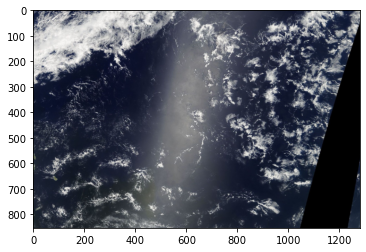

In [67]:
# Edge detection works by convolving these filters over the given image
image = plt.imread('image.jpg')
plt.imshow(image)

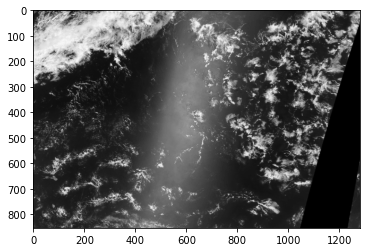

In [66]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

In [51]:
gray.shape

(853, 1280)

In [53]:
# converting to grayscale
gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
 
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [54]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.

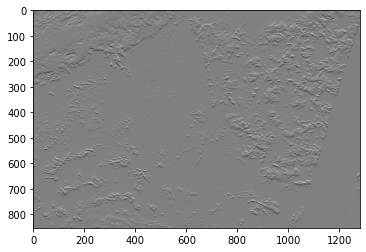

In [55]:
plt.imshow(out_h, cmap='gray')

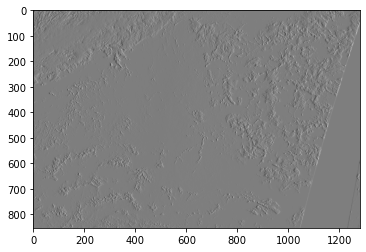

In [69]:
plt.imshow(out_v, cmap='gray')

In [57]:
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -8  1]
 [ 1  1  1]] is a laplacian kernel


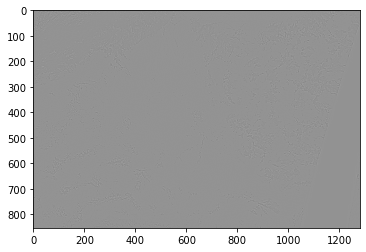

In [58]:
out_l = ndimage.convolve(gray, kernel_laplace, mode='reflect')
plt.imshow(out_l, cmap='gray')

# Atmospheric Image Segmentation based on Clustering

(853, 1280, 3)


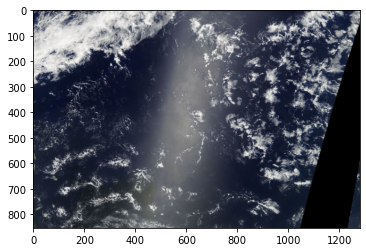

In [59]:
pic = plt.imread('image.jpg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)

In [60]:
# onvert it into a 2-dimensional array
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(1091840, 3)

In [81]:
#  fit the k-means algorithm on this reshaped array and obtain the clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

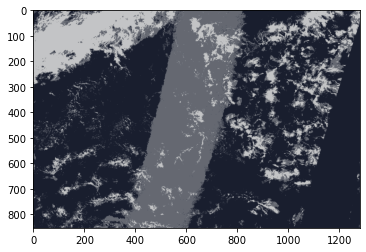

In [83]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)